In [11]:
from math import sqrt
from scipy.fft import fft
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

import numpy as np
from scipy.ndimage import maximum_filter

from utils import *

In [12]:
lamda = 0.2
min_distance = 0.1
t = 200
nbSources = 5
snr = 20

fft_size = 128

theta = np.random.rand(nbSources) * np.pi / 2
phi = np.random.rand(nbSources) * np.pi
signal = (np.random.randn(nbSources, t) + 1j * np.random.randn(nbSources, t)) / sqrt(2)

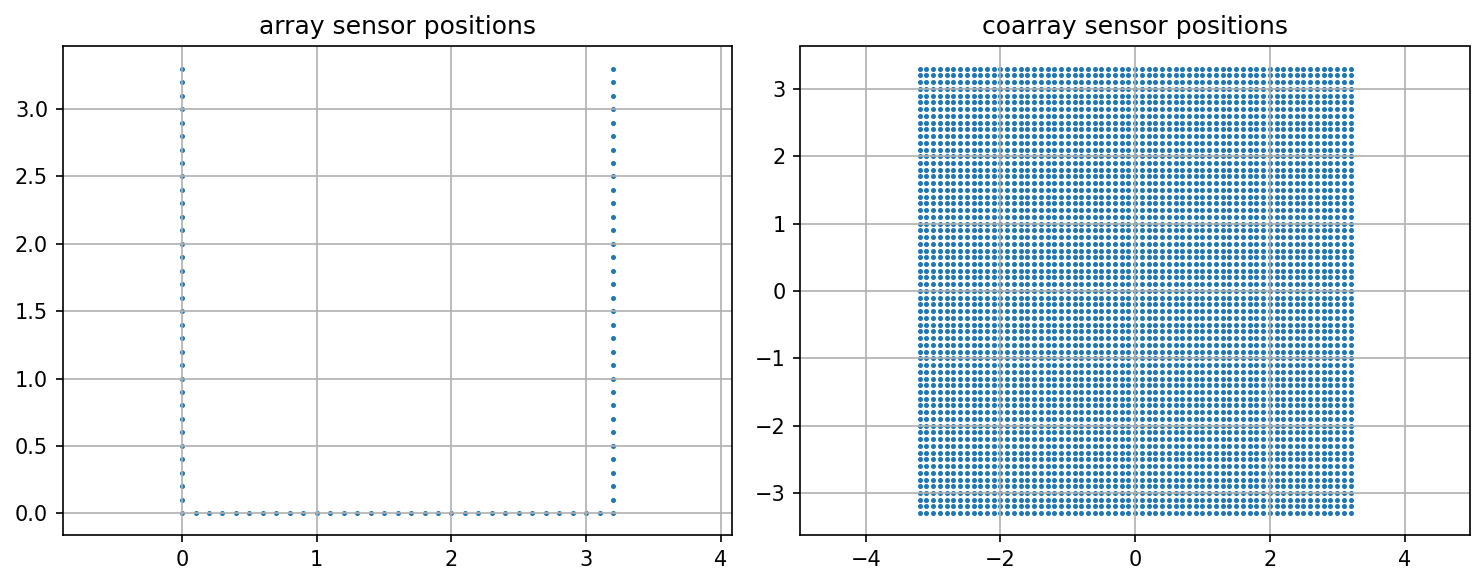

In [13]:
# array = UniformRectangularArray(lamda=lamda, min_distance=min_distance, size_horizontal=30, size_vertical=30)
array = OpenBoxArray(lamda=lamda, min_distance=min_distance, size_horizontal=33, size_vertical=34)
array.build_coarray()
array.build_array_manifold()
array.plot()

In [14]:
# array.plot_coarray_weight(plot3D=True)

In [15]:
noise = (np.random.randn(array.nbSensors, t) + 1j * np.random.randn(array.nbSensors, t)) / sqrt(2) * sqrt(nbSources) * 10 ** (-snr/20)
X = array.get_steering_vector(phi, theta) @ signal + noise

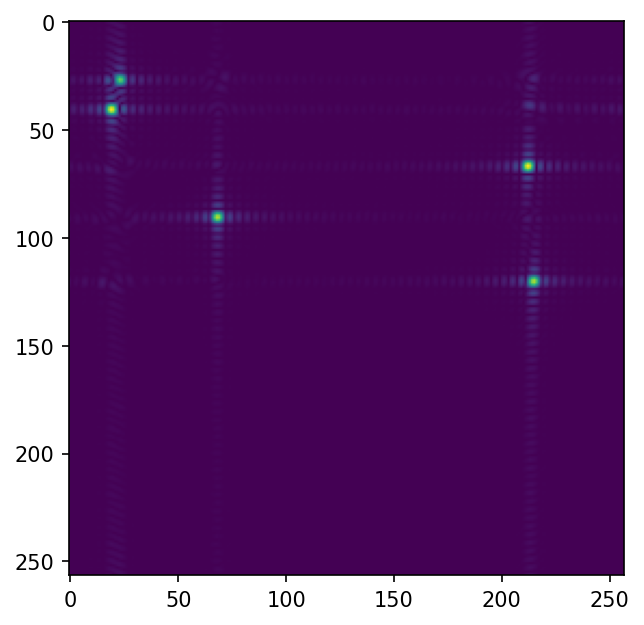

In [16]:
cov = X @ X.T.conj() / X.shape[1]
coarray_covariance = {}
for pos, indices in array.pos_coarray_dict.items():
    indices = np.array(indices)
    values = np.mean(cov[indices[:, 0], indices[:, 1]])
    coarray_covariance[pos] = values

R = np.zeros((2*fft_size+1, 2*fft_size+1), dtype=np.complex64)
for pos in array.pos_coarray_dict.keys():
    R[pos[1]+fft_size, pos[0]+fft_size] = coarray_covariance[pos]

Rfft = fft(fft(R, axis=0), axis=1)
Rfft_abs = np.abs(Rfft)
plt.imshow(Rfft_abs);

In [17]:
neighborhood = maximum_filter(Rfft_abs, size=3, mode='constant', cval=-np.inf)
peaks_mask = (Rfft_abs == neighborhood)

for shift in [(-1,0), (1,0), (0,-1), (0,1)]:
    shifted = np.roll(Rfft_abs, shift, axis=(0,1))
    mask = np.ones_like(Rfft_abs, dtype=bool)
    if shift[0] == -1:
        mask[0,:] = False
    elif shift[0] == 1:
        mask[-1,:] = False
    if shift[1] == -1:
        mask[:,0] = False
    elif shift[1] == 1:
        mask[:,-1] = False
    peaks_mask &= (Rfft_abs > shifted) | ~mask  

peak_indices = np.argwhere(peaks_mask)
peak_values = Rfft_abs[peaks_mask]
sorted_indices = np.argsort(-peak_values)
top_peaks = [peak_indices[i] for i in sorted_indices[:nbSources]]
top_peaks

[array([ 67, 212]),
 array([41, 19]),
 array([91, 68]),
 array([120, 215]),
 array([27, 23])]

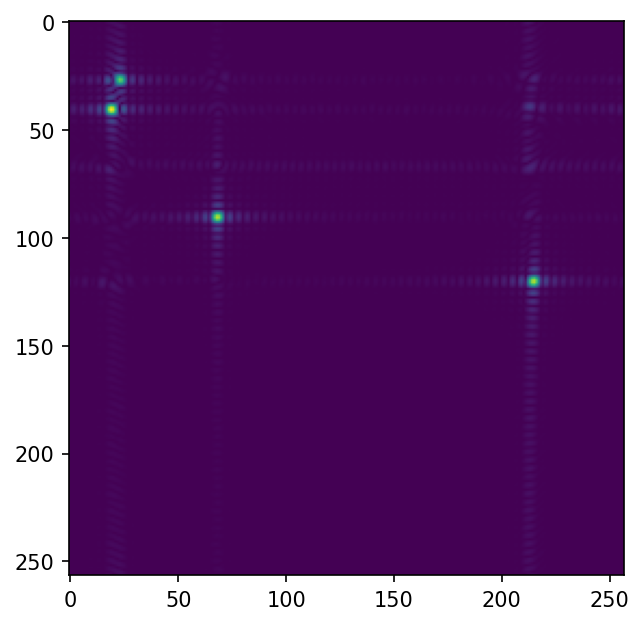

In [18]:
i, j = top_peaks[0]
del_i, del_j = get_displacement(Rfft_abs[i-1:i+2, j-1:j+2]) 
cov_tmp = np.zeros((2*fft_size+1, 2*fft_size+1), dtype=np.complex64)
for pos in array.pos_coarray_dict.keys():
    cov_tmp[pos[0]+fft_size, pos[1]+fft_size] = np.exp(1j * 2 * np.pi / (2 * fft_size + 1) * ((i + del_i) * pos[0] + (j + del_j) * pos[1]))
    # cov_tmp[pos[0]+fft_size, pos[1]+fft_size] = np.exp(1j * 2 * np.pi / (2 * fft_size + 1) * (i * pos[0] + j * pos[1]))


Rfft2 = Rfft - fft(fft(cov_tmp, axis=0), axis=1)
Rfft2_abs = np.abs(Rfft2)

plt.imshow(Rfft2_abs);

In [19]:
neighborhood = maximum_filter(Rfft2_abs, size=3, mode='constant', cval=-np.inf)
peaks_mask = (Rfft2_abs == neighborhood)

for shift in [(-1,0), (1,0), (0,-1), (0,1)]:
    shifted = np.roll(Rfft2_abs, shift, axis=(0,1))
    mask = np.ones_like(Rfft2_abs, dtype=bool)
    if shift[0] == -1:
        mask[0,:] = False
    elif shift[0] == 1:
        mask[-1,:] = False
    if shift[1] == -1:
        mask[:,0] = False
    elif shift[1] == 1:
        mask[:,-1] = False
    peaks_mask &= (Rfft2_abs > shifted) | ~mask  

peak_indices = np.argwhere(peaks_mask)
peak_values = Rfft2_abs[peaks_mask]
sorted_indices = np.argsort(-peak_values)
top_peaks = [peak_indices[i] for i in sorted_indices[:nbSources-1]]
top_peaks

[array([41, 19]), array([91, 68]), array([120, 215]), array([27, 23])]

In [20]:
# def arctan2_custom(y, x):
#     angle = np.arctan2(y, x)
#     angle = np.where(angle < 0, angle + np.pi * 2, angle)
#     angle = np.where(angle > np.pi, 2 * np.pi - angle, angle)
#     return angle 

# estimated_phi, estimated_theta = [], []

# for j, i in top_peaks:
#     if i <= (2 * fft_size + 1) * array.min_distance / array.lamda: 
#         b1 = - i / (array.min_distance / array.lamda * (2 * fft_size + 1))
#     else: b1 = (1 - i / (2 * fft_size + 1)) * array.lamda / array.min_distance
#     if j <= (2 * fft_size + 1) * array.min_distance / array.lamda: 
#         b2 = - j / (array.min_distance / array.lamda * (2 * fft_size + 1))
#     else: b2 = (1 - j / (2 * fft_size + 1)) * array.lamda / array.min_distance
#     x = np.linalg.solve(array.shear.T, np.array([b1, b2]))
#     estimated_theta.append(np.arcsin(np.clip(np.sqrt(x[0] ** 2 + x[1] ** 2), -1, 1)))
#     estimated_phi.append(arctan2_custom(- x[1], - x[0]))